In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:

# Load the dataset
df = pd.read_csv('Air_Quality.csv')


In [3]:

# Convert Start_Date to datetime and then to a numeric format
df['Start_Date'] = pd.to_datetime(df['Start_Date'])
df['Start_Date'] = df['Start_Date'].map(pd.Timestamp.toordinal)

# Encode categorical variables
le = LabelEncoder()
df['Name'] = le.fit_transform(df['Name'])
df['Measure'] = le.fit_transform(df['Measure'])
df['Measure Info'] = le.fit_transform(df['Measure Info'])
df['Geo Type Name'] = le.fit_transform(df['Geo Type Name'])
df['Geo Place Name'] = le.fit_transform(df['Geo Place Name'])
df['Message'] = le.fit_transform(df['Message'])

# Feature scaling
scaler = MinMaxScaler()
df[['Data Value', 'Normalized_Data_Value']] = scaler.fit_transform(df[['Data Value', 'Normalized_Data_Value']])

# Splitting data into features and target
X = df.drop(['Message', 'Unique ID'], axis=1)
y = df['Message']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [4]:

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print('KNN Classification Report:')
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.78
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.37      0.43       292
           1       0.81      0.84      0.83      2359
           2       0.77      0.77      0.77      2215

    accuracy                           0.78      4866
   macro avg       0.70      0.66      0.67      4866
weighted avg       0.78      0.78      0.78      4866



In [5]:

# Decision Tree with Cross-Validation and Hyperparameter Tuning
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print('Decision Tree Classification Report:')
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 1.00
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       1.00      1.00      1.00      2359
           2       1.00      1.00      1.00      2215

    accuracy                           1.00      4866
   macro avg       1.00      1.00      1.00      4866
weighted avg       1.00      1.00      1.00      4866



In [6]:

# Random Forest with Cross-Validation and Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.00
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       1.00      1.00      1.00      2359
           2       1.00      1.00      1.00      2215

    accuracy                           1.00      4866
   macro avg       1.00      1.00      1.00      4866
weighted avg       1.00      1.00      1.00      4866



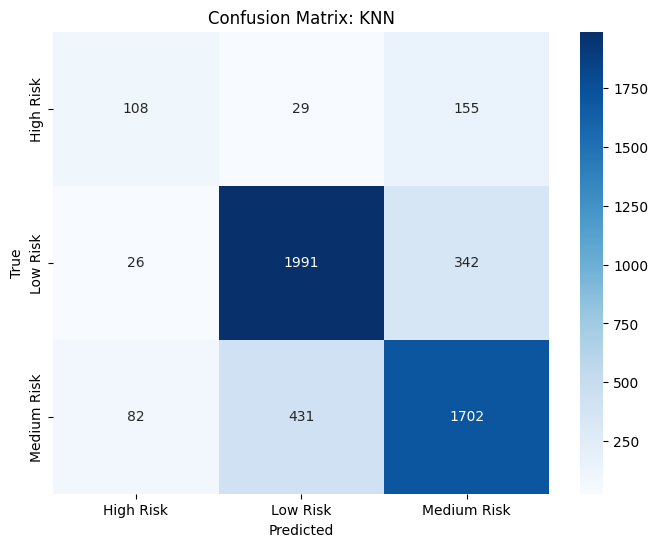

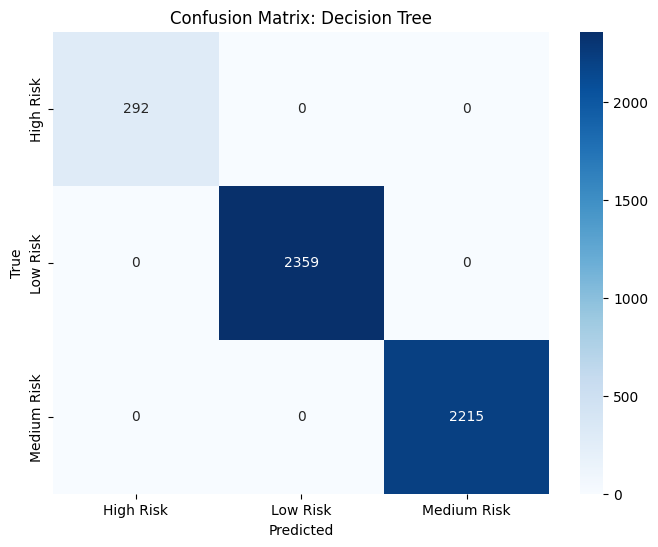

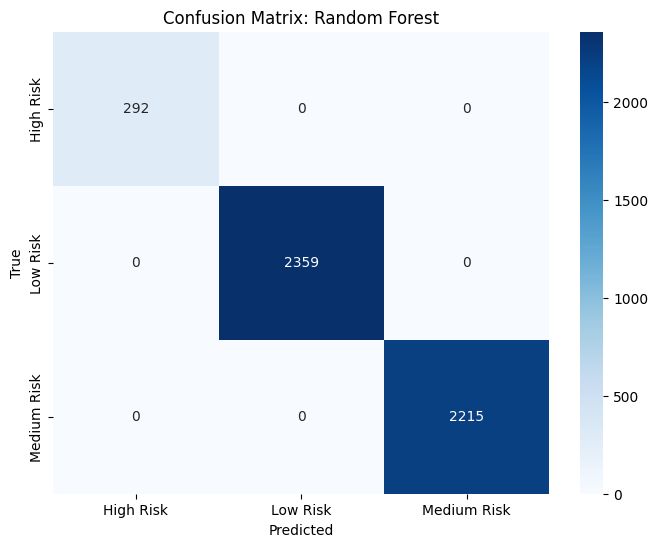

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Confusion Matrix for KNN
plot_confusion_matrix(y_test, y_pred_knn, "Confusion Matrix: KNN")

# Confusion Matrix for Decision Tree
plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix: Decision Tree")

# Confusion Matrix for Random Forest
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix: Random Forest")


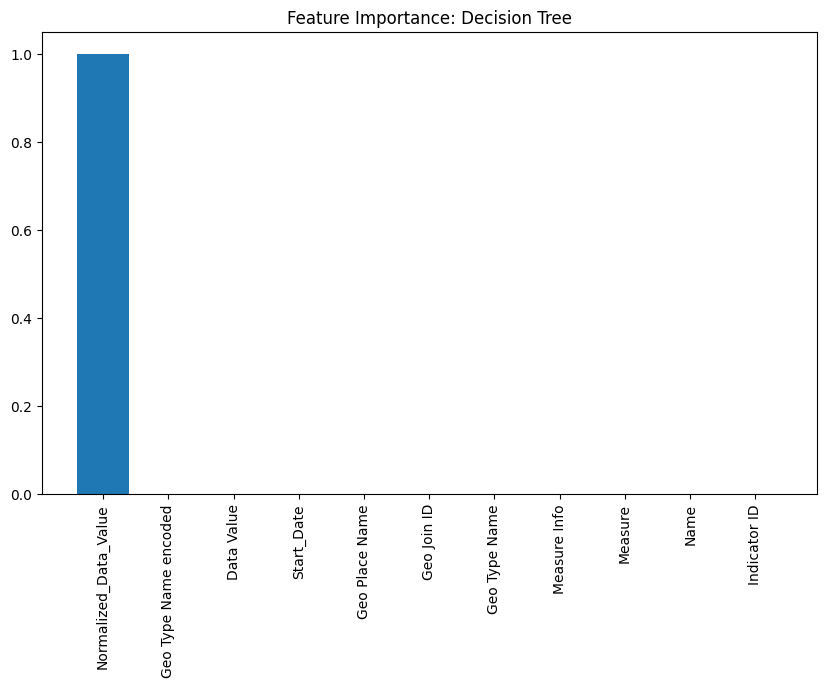

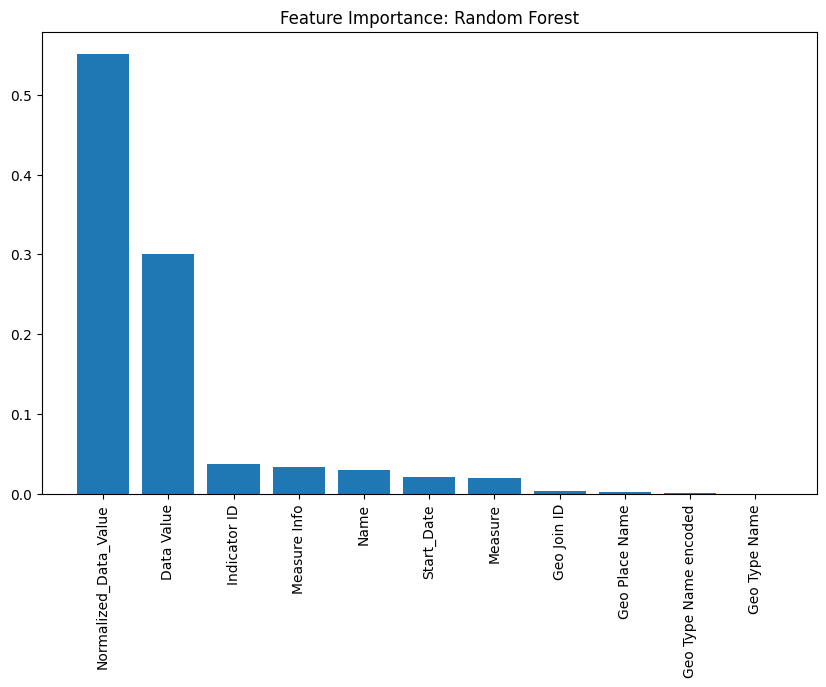

In [8]:

# Feature Importance for Decision Tree
importances_dt = best_dt.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance: Decision Tree")
plt.bar(range(X_train.shape[1]), importances_dt[indices_dt], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices_dt], rotation=90)
plt.show()

# Feature Importance for Random Forest
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance: Random Forest")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices_rf], rotation=90)
plt.show()
